# Stem Analysis

This notebook provides code to analyse and explore point cloud tree stems. As input you can either use an already separated stem point cloud or use a complete tree and use the provided separation code (see `option B` in step 1)

---------------

##### Imports

In [1]:
# Add project src to path.
import set_path

# Import modules.
import os
import numpy as np
import open3d as o3d
import logging as log
import tree as tree_utils
import utils.o3d_utils as o3d_utils
import utils.plot_utils as plot_utils
from labels import Labels

### 1. Load Data
---

**Option A**: Load stem point cloud

In [6]:
stem_cloud = o3d_utils.read_las('../datasets/preprocessed/single_121913_487434_Sonarski_stem.las')

Point cloud of 44363 points, (1.0x1.0x3.8), and 0.009 point density.


**Option B**: Load tree point cloud and separate using `src/tree.py`

In [ ]:
adTree_exe = '../../AdTree-single/build/bin/AdTree.app/Contents/MacOS/AdTree'
leaf_filtering_method = 'curvature'

# Load point cloud data
tree_cloud = o3d_utils.read_las('../datasets/single_selection/single_121913_487434_Cyclo.las')

# Separate stem from tree
stem_cloud, _ = tree_utils.tree_separate(tree_cloud, adTree_exe, filter_leaves=leaf_filtering_method)

In [7]:
o3d.visualization.draw_geometries([stem_cloud])

### 2. Stem Analysis
---

**Fit cyclinders to stem**

In [8]:
stem_cylinders = tree_utils.fit_cylinders_to_stem(stem_cloud, .25)

In [9]:
# Visualise stem fit
plot_utils.plot_stem_cylinders(stem_cylinders, resolution=25, cloud=stem_cloud)

**Circumerferential Completness Index (CCI)**

CCI is simply the fraction of a circle with point coverage in a stem slice as illustrated below. This provides an indication of how complete your stem coverage is. In a single scan TLS point cloud, you cannot get a CCI greater than 0.5 (assuming the cylinder fitting was not erroneous), as only one side of the tree is mapped. If you have completely scanned the tree (at the measurement location), you should get a CCI of 1.0 (the highest possible CCI).

![CCI.jpg](../imgs/CCI.jpg)

The figure is from this paper: https://doi.org/10.3390/rs12101652 if you would like a more detailed explanation of the idea.

In [10]:
stem_CCI = (np.min(stem_cylinders[:,4]), np.max(stem_cylinders[:,4]))
print(f" The minimal and maximal CCI of the scanned stem is {stem_CCI}")

 The minimal and maximal CCI of the scanned stem is (0.8125, 0.9875)


`Diameter at breast height` == 1.3 m

**Stem Angle**

In [11]:
stem_angle = tree_utils.stem_angle(stem_cylinders)
print(f"Stem angle is {stem_angle:.2f} degrees")

Stem angle is 5.33 degrees


**Stem Angle Direciton**

In [ ]:
# Angle to witch the stem is falling towards



**Stem Dimensions**

In [12]:
# estimate stem height
stem_height = tree_utils.stem_height(stem_cloud)
print(f"Stem height is {stem_height:.2f}")

Stem height is 3.85


In [13]:
stem_avg_circumference = 2*np.mean(stem_cylinders[:,3])*np.pi
print(f"Stem circumference is {stem_avg_circumference:.2f} m (average)")

# TODO: circumference at breast height

Stem circumference is 1.82 m (average)


In [213]:
np.degrees(np.arctan2(0, 1))
np.degrees(np.arctan2(1, 0))
np.degrees(np.arctan2(0, -1))
np.degrees(np.arctan2(-1, 0))

-90.0

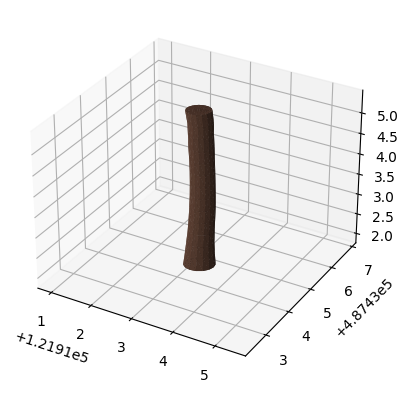

In [14]:
mesh = o3d_utils.mesh_from_cylinders(stem_cylinders, tree_utils.tree_colors['stem'])
o3d_utils.plot_mesh(mesh)

**Breast Fit**

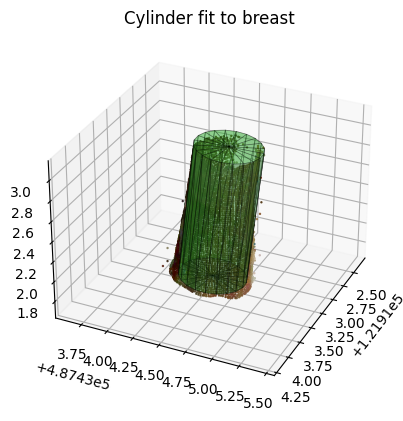

Diameter op boorsthoogte (1.3 m) is 0.62 m 
Stem xy location is [121913.28 487434.53]


In [201]:
breast_height = 1.3
breast_cylinder = tree_utils.fit_cylinder_to_breast(stem_cloud, breast_height)

print(f"Diameter op boorsthoogte ({breast_height} m) is {round(2*breast_cylinder[2],2)} m ")

**Stem Location**

In [ ]:
stem_location = tree_utils.stem_location(stem_cloud, breast_cylinder[0], breast_cylinder[1]))
print(f"Stem xy location is {np.round(stem_location[:2],2)}")

**Other**

![stem_analysis.png](../imgs/stem_analysis.png)